Import a bunch of stuff

In [41]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from botorch.models import ModelListGP, SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Random data generation

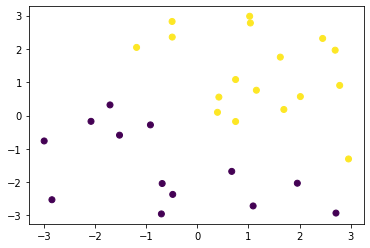

In [42]:
def getRand(r1, r2, num):
    return (r1 - r2) * torch.rand(num, 1) + r2
    
def gen_data(num_data):
    x = getRand(-3, 3, num_data)
    y = getRand(-3, 3, num_data)
    data_fn = lambda x, y: torch.sin(0.15 * 3.1415 * (x + y)) + 1
    latent_fn = data_fn(x, y)
    z = latent_fn.long()  # This will convert z to integers 
                          # (Do not squeeze, SingleTask GP requires 2xD)
    return torch.cat((x,y),dim=1), z, data_fn

train_x, train_y, genfn = gen_data(30)
plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = train_y)

Plot actual boundries

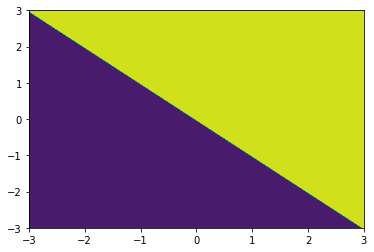

In [43]:
test_d1 = np.linspace(-3, 3, 150)
test_d2 = np.linspace(-3, 3, 150)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

test_labels = genfn(test_x_mat, test_y_mat).long().squeeze() #Convert to integers (0 or 1)

test_y = test_labels.view(-1)

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [44]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

ECI stuff

In [45]:
# def smooth_mask(x, a, eps=2e-3):
#     """Returns 0ish for x < a and 1ish for x > a"""
#     return torch.nn.Sigmoid()((x - a) / eps)


# def smooth_box_mask(x, a, b, eps=2e-3):
#     """Returns 1ish for a < x < b and 0ish otherwise"""
#     return smooth_mask(x, a, eps) - smooth_mask(x, b, eps)

# class ExpectedCoverageImprovement(MCAcquisitionFunction):
#     def __init__(
#         self,
#         model,
#         constraints,
#         punchout_radius,
#         bounds,
#         num_samples=512,
#         **kwargs,
#     ):
#         """Expected Coverage Improvement (q=1 required, analytic)

#         Right now, we assume that all the models in the ModelListGP have
#         the same training inputs.

#         Args:
#             model: A ModelListGP object containing models matching the corresponding constraints.
#                 All models are assumed to have the same training data.
#             constraints: List containing 2-tuples with (direction, value), e.g.,
#                 [('gt', 3), ('lt', 4)]. It is necessary that
#                 len(constraints) == model.num_outputs.
#             punchout_radius: Positive value defining the desired minimum distance between points
#             bounds: torch.tensor whose first row is the lower bounds and second row is the upper bounds
#             num_samples: Number of samples for MC integration
#         """
#         super().__init__(model=model, objective=IdentityMCObjective(), **kwargs)
#         assert len(constraints) == model.num_outputs
#         assert all(direction in ("gt", "lt") for direction, _ in constraints)
#         assert punchout_radius > 0
#         self.constraints = constraints
#         self.punchout_radius = punchout_radius
#         self.bounds = bounds
#         self.base_points = self.train_inputs
#         self.ball_of_points = self._generate_ball_of_points(
#             num_samples=num_samples,
#             radius=punchout_radius,
#             device=bounds.device,
#             dtype=bounds.dtype,
#         )
#         self._thresholds = torch.tensor(
#             [threshold for _, threshold in self.constraints]
#         ).to(bounds)
#         assert (
#             all(ub > lb for lb, ub in self.bounds.T) and len(self.bounds.T) == self.dim
#         )

#     @property
#     def num_outputs(self):
#         return self.model.num_outputs

#     @property
#     def dim(self):
#         return self.train_inputs.shape[-1]

#     @property
#     def train_inputs(self):
#         return self.model.models[0].train_inputs[0]

#     def _generate_ball_of_points(
#         self, num_samples, radius, device=None, dtype=torch.double
#     ):
#         """Creates a ball of points to be used for MC."""
#         tkwargs = {"device": device, "dtype": dtype}
#         z = sample_hypersphere(d=self.dim, n=num_samples, qmc=True, **tkwargs)
#         r = torch.rand(num_samples, 1, **tkwargs) ** (1 / self.dim)
#         return radius * r * z

#     def _get_base_point_mask(self, X):
#         distance_matrix = self.model.models[0].covar_module.base_kernel.covar_dist(
#             X, self.base_points
#         )
#         return smooth_mask(distance_matrix, self.punchout_radius)

#     def _estimate_probabilities_of_satisfaction_at_points(self, points):
#         """Estimate the probability of satisfying the given constraints."""
#         posterior = self.model.posterior(X=points)
#         mus, sigma2s = posterior.mean, posterior.variance
#         dist = torch.distributions.normal.Normal(mus, sigma2s.sqrt())
#         norm_cdf = dist.cdf(self._thresholds)
#         probs = torch.ones(points.shape[:-1]).to(points)
#         for i, (direction, _) in enumerate(self.constraints):
#             probs = probs * (
#                 norm_cdf[..., i] if direction == "lt" else 1 - norm_cdf[..., i]
#             )
#         return probs

#     @t_batch_mode_transform(expected_q=1)
#     def forward(self, X):
#         """Evaluate Expected Improvement on the candidate set X."""
#         ball_around_X = self.ball_of_points + X
#         domain_mask = smooth_mask(
#             ball_around_X, self.bounds[0, :], self.bounds[1, :]
#         ).prod(dim=-1)
#         num_points_in_integral = domain_mask.sum(dim=-1)
#         base_point_mask = self._get_base_point_mask(ball_around_X).prod(dim=-1)
#         prob = self._estimate_probabilities_of_satisfaction_at_points(ball_around_X)
#         masked_prob = prob * domain_mask * base_point_mask
#         y = masked_prob.sum(dim=-1) / num_points_in_integral
#         return y

SingleTask GP

In [46]:
import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random

In [47]:
octf = Standardize(m=train_y.shape[-1])
train_x = torch.tensor(train_x, dtype=torch.float64) #Set dtype to compatible type
train_y = torch.tensor(train_y, dtype=torch.float64)
# print(train_x)
# print(train_y)
likelihood = GaussianLikelihood(noise_constraint=Interval(1e-6, 1e-3))
model = SingleTaskGP(train_x, train_y, likelihood=likelihood, outcome_transform=octf)

C:\Users\Leo\AppData\Local\Temp\ipykernel_31584\979753141.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x, dtype=torch.float64) #Set dtype to compatible type
C:\Users\Leo\AppData\Local\Temp\ipykernel_31584\979753141.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.float64)


In [48]:
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(1.000E-06, 1.000E-03)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (raw_noise_constraint): Interval(1.000E-06, 1.000E-03)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
  )
)

In [49]:
# import os
# smoke_test = ('CI' in os.environ)
# training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
# model.train()
# likelihood.train()

# Use the adam optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood


# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, likelihood.transformed_targets).sum()
#     loss.backward()
#     if i % 5 == 0:
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#             i + 1, training_iter, loss.item(),
#             model.covar_module.base_kernel.lengthscale.mean().item(),
#             model.likelihood.second_noise_covar.noise.mean().item()
#         ))
#     optimizer.step()

In [50]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = model(test_x.double())

    pred_means = test_dist.loc
pred_means = torch.unsqueeze(pred_means,0) # Unsqueeze to get correct tensor shape


Text(0.5, 1.0, 'Logits: Class 0')

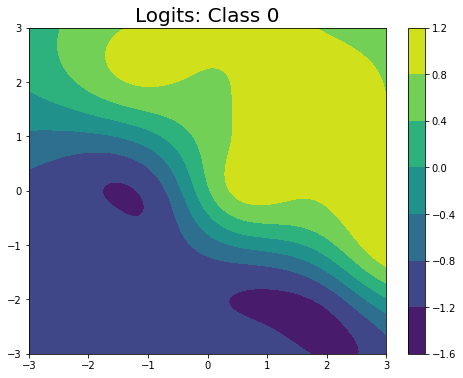

In [51]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
im = ax.contourf(
    test_x_mat.numpy(), test_y_mat.numpy(), pred_means.numpy().reshape((150,150))
)
fig.colorbar(im, ax=ax)
ax.set_title("Logits: Class " + str(0), fontsize = 20)

In [52]:
pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
probabilities = torch.unsqueeze(probabilities,0) # Unsqueeze to get correct tensor shape

Text(0.5, 1.0, 'Probabilities: Class 0')

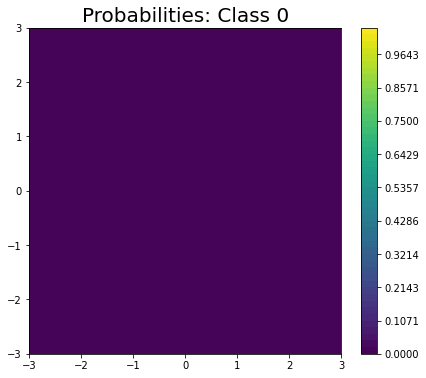

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (7, 6))
levels = np.linspace(0, 1.05, 50)

im = ax.contourf(
    test_x_mat.numpy(), test_y_mat.numpy(), probabilities.numpy().reshape((150,150)), levels=levels
)
fig.colorbar(im, ax=ax)
ax.set_title("Probabilities: Class " + str(0), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

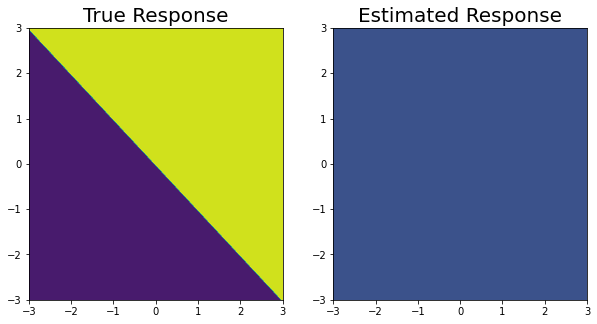

In [54]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((150,150)))
ax[1].set_title('Estimated Response', fontsize=20)